In [1]:
import os
from tqdm import tqdm
import numpy as np
import pandas as pd
from itertools import accumulate
import matplotlib.pyplot as plt
import seaborn as sns
from PIL import Image

%matplotlib inline

import torch
from torch.utils.data import TensorDataset, DataLoader,Dataset, random_split
import torch.nn as nn
import torchvision
import torchvision.transforms as transforms
import torch.optim as optim

def warn(*args, **kwargs):
    pass
import warnings
warnings.warn = warn
warnings.filterwarnings('ignore')

sns.set_context('notebook')
sns.set_style('white')

In [2]:
path_data = '/kaggle/input/histopathologic-cancer-detection'
print(os.listdir(path_data))

print(os.listdir(os.path.join(path_data, 'train'))[:5])
print(os.listdir(os.path.join(path_data, 'test'))[:5])

['sample_submission.csv', 'train_labels.csv', 'test', 'train']
['d43c081bafa286f9c1f7e921883f26ceafebc912.tif', '092d0eedebce504847715ee046b6ad74b57599b4.tif', 'b0d2582c6218a8764323fc940b41312282b99bf4.tif', '187c99df762f13f99818e5593d4bab4c6577e7e3.tif', '7c5270c83837de5a5cbb2dca511559dc39d19d53.tif']
['a7ea26360815d8492433b14cd8318607bcf99d9e.tif', '59d21133c845dff1ebc7a0c7cf40c145ea9e9664.tif', '5fde41ce8c6048a5c2f38eca12d6528fa312cdbb.tif', 'bd953a3b1db1f7041ee95ff482594c4f46c73ed0.tif', '523fc2efd7aba53e597ab0f69cc2cbded7a6ce62.tif']


In [3]:
from torch.cuda import is_available, get_device_name

if is_available():
    print(f"The environment has a compatible GPU ({get_device_name()}) available.")
else:
    print(f"The environment does NOT have a compatible GPU model available.")

The environment has a compatible GPU (Tesla T4) available.


In [4]:
from numpy import clip , array
from matplotlib import pyplot as plt
from torch import Tensor

def imshow(inp: Tensor) -> None:
    """Imshow for Tensor."""
    inp = inp.cpu().numpy()
    inp = inp.transpose((1, 2, 0))
    mean = array([0.485, 0.456, 0.406])
    std = array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = clip(inp, 0, 1)
    plt.imshow(inp)
    plt.show()

# Dataset

In [5]:
## Load the label of data
labels_df = pd.read_csv("/kaggle/input/histopathologic-cancer-detection/train_labels.csv")
labels_df.head()

,id,label
0,f38a6374c348f90b587e046aac6079959adf3835,0
1,c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
2,755db6279dae599ebb4d39a9123cce439965282d,0
3,bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
4,068aba587a4950175d04c680d38943fd488d6a9d,0


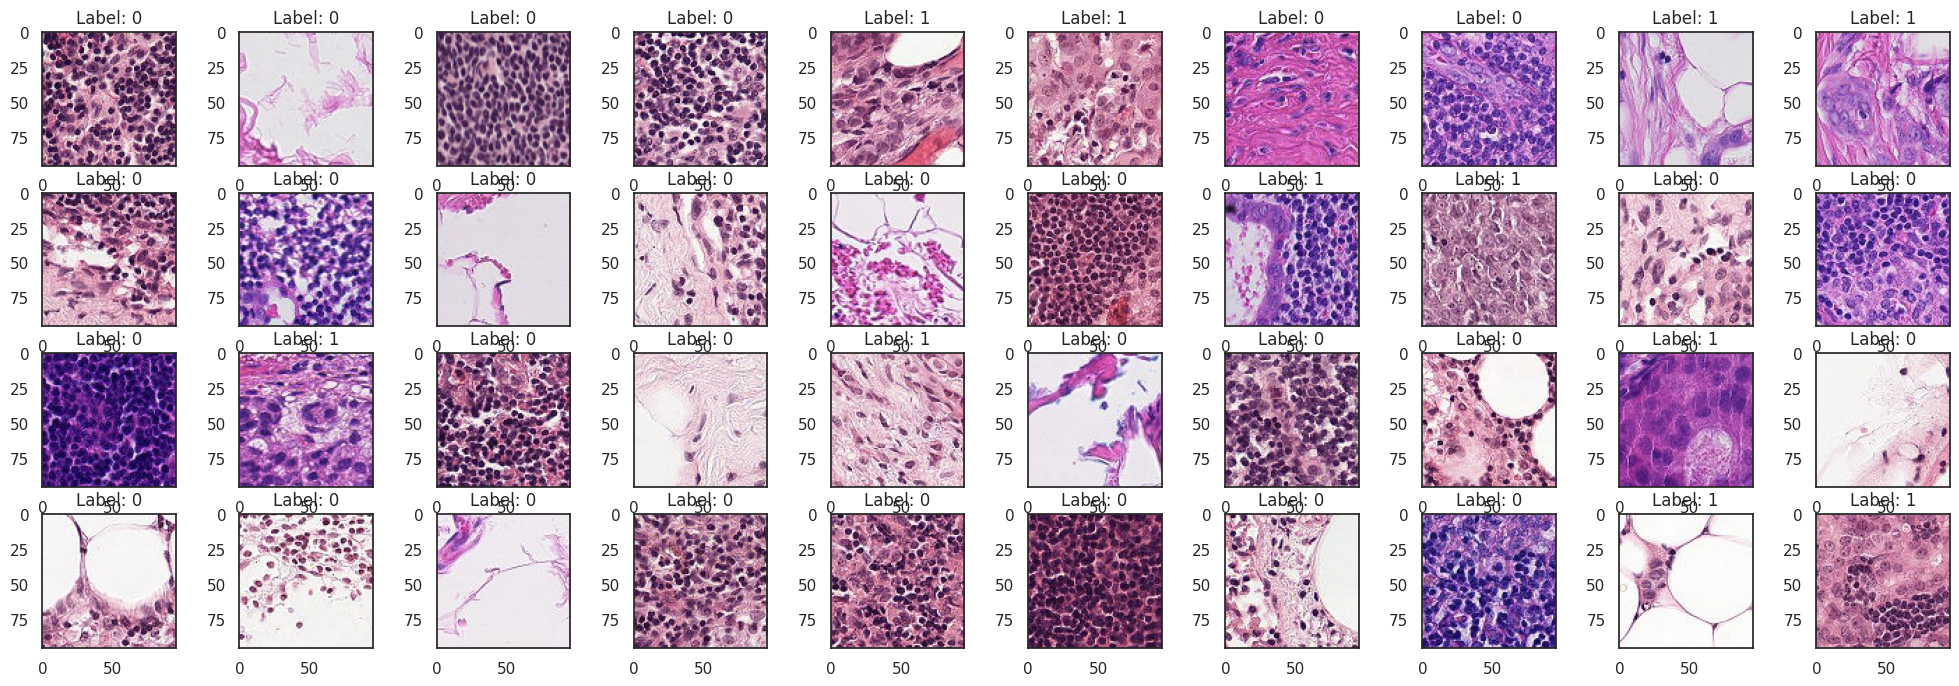

In [6]:
fig = plt.figure(figsize=(25, 8))

train_imgs = os.listdir(os.path.join(path_data, 'train'))

for idx, img in enumerate(np.random.choice(train_imgs, 40)):

    ax = fig.add_subplot(4, 40//4, idx+1)

    im = Image.open(os.path.join(path_data, 'train', img))

    plt.imshow(im)

    lab = labels_df.loc[labels_df["id"] == img.split('.')[0], 'label'].values[0]

    ax.set_title(f"Label: {lab}")


# Data Preparation

In [7]:
labels_df.shape

(220025, 2)

In [8]:
labels_df = labels_df.set_index('id')
labels_df

,label
id,
f38a6374c348f90b587e046aac6079959adf3835,0
c18f2d887b7ae4f6742ee445113fa1aef383ed77,1
755db6279dae599ebb4d39a9123cce439965282d,0
bc3f0c64fb968ff4a8bd33af6971ecae77c75e08,0
068aba587a4950175d04c680d38943fd488d6a9d,0
...,...
53e9aa9d46e720bf3c6a7528d1fca3ba6e2e49f6,0
d4b854fe38b07fe2831ad73892b3cec877689576,1
3d046cead1a2a5cbe00b2b4847cfb7ba7cf5fe75,0


In [9]:
import random

random.seed(666)
idx = list(labels_df.index)
idx[:5]

['f38a6374c348f90b587e046aac6079959adf3835',
 'c18f2d887b7ae4f6742ee445113fa1aef383ed77',
 '755db6279dae599ebb4d39a9123cce439965282d',
 'bc3f0c64fb968ff4a8bd33af6971ecae77c75e08',
 '068aba587a4950175d04c680d38943fd488d6a9d']

In [10]:
idx_p = list(range(len(idx)))
print(idx_p[:5])
random.shuffle(idx_p)
print(idx_p[:5])

[0, 1, 2, 3, 4]
[85176, 21660, 210433, 161339, 157632]


In [11]:
idx_random = [idx[x] for x in idx_p]
idx_random[:5]

['1d50f988780dfea563069c2c41b91e2820811b11',
 '47fcfc631a5f7b1062fbcc8363d2378b61dfe990',
 '927f604101b7de12d81d919385e06d4410671136',
 '8f3705e6554653fd53c520f93ac2b10a8803c79c',
 '6d298223696d8a7f055f4449f9e2fff9ee7c4423']

In [12]:
total = len(idx_random)
idx_70 = int(total * 0.70)
idx_90 = int(total * 0.90)

idx_frac_70 = idx_random[:idx_70] 
idx_frac_20 = idx_random[idx_70:idx_90]
idx_frac_10 = idx_random[idx_90:] 

print(f"(70%): {len(idx_frac_70)} itens")
print(f"(20%): {len(idx_frac_20)} itens")
print(f"(10%): {len(idx_frac_10)} itens")
print(f"Total: {len(idx_frac_70) + len(idx_frac_20) + len(idx_frac_10)} itens")

(70%): 154017 itens
(20%): 44005 itens
(10%): 22003 itens
Total: 220025 itens


In [13]:
from pathlib import Path

class CancerDataset(Dataset):
    def __init__(
        self,
        path_to_dataset: str,
        transform,
        dataset_type=None):

        path_dataset = Path(path_to_dataset)
        if not path_dataset.is_dir():
            raise OSError('This is not directory')

        check_data_split =  ['train', 'test']
        sub_dirs = [os.path.basename(str(x)) for x in path_dataset.iterdir()]
        
        if not check_data_split[0] in sub_dirs and not check_data_split[1] in sub_dirs:
            raise Exception('Does not exists train dir or test dir')

        self.path_dataset_train = path_dataset.joinpath(check_data_split[0])
        self.path_dataset_test = path_dataset.joinpath(check_data_split[1])

        if not 'train_labels.csv' in sub_dirs:
            raise Exception('File labels does not found')
        
        self.labels_file = path_dataset / "train_labels.csv"
        self.df_labels = pd.read_csv(self.labels_file)
        self.df_labels.set_index("id", inplace=True)

        random.seed(666)
        idx = list(labels_df.index)
        idx_p = list(range(len(idx)))
        random.shuffle(idx_p)
        idx_random = [idx[x] for x in idx_p]

        total = len(idx_random)
        idx_70 = int(total * 0.70)
        idx_90 = int(total * 0.90)
        
        idx_frac_70 = idx_random[:idx_70] 
        idx_frac_20 = idx_random[idx_70:idx_90]
        idx_frac_10 = idx_random[idx_90:] 
        
        #print(f"Total: {len(idx_frac_70) + len(idx_frac_20) + len(idx_frac_10)} itens")
    
        if dataset_type == "train":
            self.labels = list(self.df_labels.loc[idx_frac_70, 'label'])
            self.full_filenames = [self.path_dataset_train / f"{f}.tif" for f in idx_frac_70]
            print(f"(70%): {len(idx_frac_70)} itens")
            print("training dataset")
            
        elif dataset_type == "val":
            self.labels = list(self.df_labels.loc[idx_frac_20, 'label'])
            self.full_filenames = [self.path_dataset_train / f"{f}.tif" for f in idx_frac_20]
            print(f"(20%): {len(idx_frac_20)} itens")
            print("validation dataset")
            
        elif dataset_type == "test":
            self.labels = list(self.df_labels.loc[idx_frac_10, 'label'])
            self.full_filenames = [self.path_dataset_train / f"{f}.tif" for f in idx_frac_10]
            print("testing dataset")
            print(f"(10%): {len(idx_frac_10)} itens")
            
        else:
            raise Exception('Fail')

        self.transform = transform

    def __len__(self):
        return len(self.full_filenames)

    def __getitem__(self, idx):
        img = Image.open(self.full_filenames[idx]) # PIL image
        img = self.transform(img)
        
        return img, self.labels[idx]

In [14]:
from torchvision import transforms

mean = [0.485, 0.456, 0.406]
std = [0.229, 0.224, 0.225]
transform_train = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.RandomHorizontalFlip(),
                               transforms.RandomRotation(degrees=5),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

transform_pos_processing = transforms.Compose([
                               transforms.Resize((224, 224)),
                               transforms.ToTensor(),
                               transforms.Normalize(mean, std)
                               ])

In [15]:
path_data

'/kaggle/input/histopathologic-cancer-detection'

In [16]:
str(next(Path(path_data).iterdir()))

'/kaggle/input/histopathologic-cancer-detection/sample_submission.csv'

In [17]:
training_set = CancerDataset(
    path_to_dataset=path_data,
    transform=transform_train,
    dataset_type="train"
)
 
validation_set = CancerDataset(
    path_to_dataset=path_data,
    transform=transform_pos_processing,
    dataset_type="val"
)

test_set = CancerDataset(
    path_to_dataset=path_data,
    transform=transform_pos_processing,
    dataset_type="test"
)

print(f'training dataset length: {len(training_set)}')
print(f'validation dataset length: {len(validation_set)}')
print(f'test dataset length: {len(test_set)}')


(70%): 154017 itens
training dataset
(20%): 44005 itens
validation dataset
testing dataset
(10%): 22003 itens
training dataset length: 154017
validation dataset length: 44005
test dataset length: 22003


In [18]:
train_loader = torch.utils.data.DataLoader(
    training_set,
    batch_size=10,
    shuffle=True,
    num_workers=2)

test_loader = torch.utils.data.DataLoader(
    test_set,
    batch_size=10,
    shuffle=False,
    num_workers=2)

N_CLASSES: int = 2
BATCH_SIZE: int = 30
LEARNING_RATE: float = 3e-4
N_EPOCHS: int = 2
print("done")

done


In [19]:
from torchvision import models

model = models.resnet34(
    pretrained=True
)

Downloading: "https://download.pytorch.org/models/resnet34-b627a593.pth" to /root/.cache/torch/hub/checkpoints/resnet34-b627a593.pth


100%|██████████| 83.3M/83.3M [00:00<00:00, 198MB/s]


In [20]:
from torch.nn import CrossEntropyLoss

criterion = CrossEntropyLoss()

In [21]:
from torch.optim import Adam

optimizer: Adam = Adam(
    model.parameters(),
    lr=LEARNING_RATE
)

In [22]:
for param in model.parameters():
    param.requires_grad = False

num_ftrs = model.fc.in_features
model.fc = nn.Linear(num_ftrs, N_CLASSES)

# Train and Test the Model

In [23]:
for epoch in range(N_EPOCHS):
    running_loss = 0.0
    for i, data in enumerate(tqdm(train_loader)):
        inputs, labels = data
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()

        if i % 100 == 99:
            tqdm.write('[%d, %5d] loss: %.3f' % (epoch + 1, i + 1, running_loss / 100))
            running_loss = 0.0


  1%|          | 100/15402 [00:48<2:03:30,  2.06it/s]

[1,   100] loss: 0.685


  1%|▏         | 200/15402 [01:37<2:02:05,  2.08it/s]

[1,   200] loss: 0.698


  2%|▏         | 300/15402 [02:25<2:02:30,  2.05it/s]

[1,   300] loss: 0.689


  3%|▎         | 400/15402 [03:12<1:58:33,  2.11it/s]

[1,   400] loss: 0.714


  3%|▎         | 500/15402 [04:00<1:57:14,  2.12it/s]

[1,   500] loss: 0.683


  4%|▍         | 600/15402 [04:48<2:00:07,  2.05it/s]

[1,   600] loss: 0.684


  5%|▍         | 700/15402 [05:36<1:56:33,  2.10it/s]

[1,   700] loss: 0.703


  5%|▌         | 800/15402 [06:24<1:55:37,  2.10it/s]

[1,   800] loss: 0.664


  6%|▌         | 900/15402 [07:12<1:53:49,  2.12it/s]

[1,   900] loss: 0.698


  6%|▋         | 1000/15402 [08:00<1:53:21,  2.12it/s]

[1,  1000] loss: 0.704


  7%|▋         | 1100/15402 [08:48<1:52:45,  2.11it/s]

[1,  1100] loss: 0.723


  8%|▊         | 1200/15402 [09:36<1:53:21,  2.09it/s]

[1,  1200] loss: 0.699


  8%|▊         | 1300/15402 [10:24<1:51:25,  2.11it/s]

[1,  1300] loss: 0.713


  9%|▉         | 1400/15402 [11:12<1:50:33,  2.11it/s]

[1,  1400] loss: 0.684


 10%|▉         | 1500/15402 [12:00<1:50:39,  2.09it/s]

[1,  1500] loss: 0.675


 10%|█         | 1600/15402 [12:48<1:52:00,  2.05it/s]

[1,  1600] loss: 0.697


 11%|█         | 1700/15402 [13:36<1:51:22,  2.05it/s]

[1,  1700] loss: 0.667


 12%|█▏        | 1800/15402 [14:24<1:51:16,  2.04it/s]

[1,  1800] loss: 0.699


 12%|█▏        | 1900/15402 [15:12<1:47:03,  2.10it/s]

[1,  1900] loss: 0.691


 13%|█▎        | 2000/15402 [16:00<1:46:02,  2.11it/s]

[1,  2000] loss: 0.662


 14%|█▎        | 2100/15402 [16:48<1:46:33,  2.08it/s]

[1,  2100] loss: 0.716


 14%|█▍        | 2200/15402 [17:37<1:44:52,  2.10it/s]

[1,  2200] loss: 0.692


 15%|█▍        | 2300/15402 [18:25<1:45:16,  2.07it/s]

[1,  2300] loss: 0.694


 16%|█▌        | 2400/15402 [19:13<1:44:43,  2.07it/s]

[1,  2400] loss: 0.689


 16%|█▌        | 2500/15402 [20:01<1:42:32,  2.10it/s]

[1,  2500] loss: 0.691


 17%|█▋        | 2600/15402 [20:49<1:43:11,  2.07it/s]

[1,  2600] loss: 0.694


 18%|█▊        | 2700/15402 [21:36<1:40:21,  2.11it/s]

[1,  2700] loss: 0.699


 18%|█▊        | 2800/15402 [22:25<1:44:16,  2.01it/s]

[1,  2800] loss: 0.686


 19%|█▉        | 2900/15402 [23:13<1:38:54,  2.11it/s]

[1,  2900] loss: 0.698


 19%|█▉        | 3000/15402 [24:01<1:39:48,  2.07it/s]

[1,  3000] loss: 0.675


 20%|██        | 3100/15402 [24:49<1:38:56,  2.07it/s]

[1,  3100] loss: 0.658


 21%|██        | 3200/15402 [25:37<1:37:01,  2.10it/s]

[1,  3200] loss: 0.686


 21%|██▏       | 3300/15402 [26:25<1:36:56,  2.08it/s]

[1,  3300] loss: 0.670


 22%|██▏       | 3400/15402 [27:13<1:35:43,  2.09it/s]

[1,  3400] loss: 0.693


 23%|██▎       | 3500/15402 [28:01<1:32:41,  2.14it/s]

[1,  3500] loss: 0.714


 23%|██▎       | 3600/15402 [28:48<1:33:33,  2.10it/s]

[1,  3600] loss: 0.690


 24%|██▍       | 3700/15402 [29:37<1:33:02,  2.10it/s]

[1,  3700] loss: 0.676


 25%|██▍       | 3800/15402 [30:26<1:45:43,  1.83it/s]

[1,  3800] loss: 0.666


 25%|██▌       | 3900/15402 [31:17<1:32:27,  2.07it/s]

[1,  3900] loss: 0.713


 26%|██▌       | 4000/15402 [32:06<1:31:17,  2.08it/s]

[1,  4000] loss: 0.692


 27%|██▋       | 4100/15402 [32:54<1:33:46,  2.01it/s]

[1,  4100] loss: 0.678


 27%|██▋       | 4200/15402 [33:43<1:30:02,  2.07it/s]

[1,  4200] loss: 0.716


 28%|██▊       | 4300/15402 [34:31<1:28:27,  2.09it/s]

[1,  4300] loss: 0.693


 29%|██▊       | 4400/15402 [35:19<1:27:07,  2.10it/s]

[1,  4400] loss: 0.683


 29%|██▉       | 4500/15402 [36:08<1:26:05,  2.11it/s]

[1,  4500] loss: 0.704


 30%|██▉       | 4600/15402 [36:56<1:26:49,  2.07it/s]

[1,  4600] loss: 0.697


 31%|███       | 4700/15402 [37:44<1:30:33,  1.97it/s]

[1,  4700] loss: 0.683


 31%|███       | 4800/15402 [38:32<1:25:22,  2.07it/s]

[1,  4800] loss: 0.710


 32%|███▏      | 4900/15402 [39:21<1:22:45,  2.11it/s]

[1,  4900] loss: 0.714


 32%|███▏      | 5000/15402 [40:09<1:32:51,  1.87it/s]

[1,  5000] loss: 0.694


 33%|███▎      | 5100/15402 [40:59<1:24:31,  2.03it/s]

[1,  5100] loss: 0.690


 34%|███▍      | 5200/15402 [41:48<1:22:51,  2.05it/s]

[1,  5200] loss: 0.679


 34%|███▍      | 5300/15402 [42:37<1:21:52,  2.06it/s]

[1,  5300] loss: 0.690


 35%|███▌      | 5400/15402 [43:25<1:21:21,  2.05it/s]

[1,  5400] loss: 0.689


 36%|███▌      | 5500/15402 [44:13<1:20:10,  2.06it/s]

[1,  5500] loss: 0.706


 36%|███▋      | 5600/15402 [45:01<1:17:33,  2.11it/s]

[1,  5600] loss: 0.674


 37%|███▋      | 5700/15402 [45:50<1:18:16,  2.07it/s]

[1,  5700] loss: 0.690


 38%|███▊      | 5800/15402 [46:38<1:15:22,  2.12it/s]

[1,  5800] loss: 0.657


 38%|███▊      | 5900/15402 [47:27<1:16:04,  2.08it/s]

[1,  5900] loss: 0.696


 39%|███▉      | 6000/15402 [48:15<1:17:37,  2.02it/s]

[1,  6000] loss: 0.710


 40%|███▉      | 6100/15402 [49:03<1:12:54,  2.13it/s]

[1,  6100] loss: 0.702


 40%|████      | 6200/15402 [49:50<1:10:13,  2.18it/s]

[1,  6200] loss: 0.693


 41%|████      | 6300/15402 [50:37<1:10:26,  2.15it/s]

[1,  6300] loss: 0.691


 42%|████▏     | 6400/15402 [51:24<1:09:32,  2.16it/s]

[1,  6400] loss: 0.688


 42%|████▏     | 6500/15402 [52:10<1:08:14,  2.17it/s]

[1,  6500] loss: 0.705


 43%|████▎     | 6600/15402 [52:57<1:07:57,  2.16it/s]

[1,  6600] loss: 0.689


 44%|████▎     | 6700/15402 [53:43<1:06:28,  2.18it/s]

[1,  6700] loss: 0.663


 44%|████▍     | 6800/15402 [54:30<1:15:24,  1.90it/s]

[1,  6800] loss: 0.667


 45%|████▍     | 6900/15402 [55:16<1:05:32,  2.16it/s]

[1,  6900] loss: 0.679


 45%|████▌     | 7000/15402 [56:03<1:08:36,  2.04it/s]

[1,  7000] loss: 0.706


 46%|████▌     | 7100/15402 [56:50<1:05:34,  2.11it/s]

[1,  7100] loss: 0.673


 47%|████▋     | 7200/15402 [57:38<1:05:28,  2.09it/s]

[1,  7200] loss: 0.707


 47%|████▋     | 7300/15402 [58:26<1:03:41,  2.12it/s]

[1,  7300] loss: 0.672


 48%|████▊     | 7400/15402 [59:13<1:03:20,  2.11it/s]

[1,  7400] loss: 0.688


 49%|████▊     | 7500/15402 [1:00:01<1:01:37,  2.14it/s]

[1,  7500] loss: 0.711


 49%|████▉     | 7600/15402 [1:00:48<1:00:24,  2.15it/s]

[1,  7600] loss: 0.698


 50%|████▉     | 7700/15402 [1:01:36<59:47,  2.15it/s]  

[1,  7700] loss: 0.719


 51%|█████     | 7800/15402 [1:02:24<1:02:16,  2.03it/s]

[1,  7800] loss: 0.713


 51%|█████▏    | 7900/15402 [1:03:12<1:00:48,  2.06it/s]

[1,  7900] loss: 0.686


 52%|█████▏    | 8000/15402 [1:04:00<58:28,  2.11it/s]

[1,  8000] loss: 0.688


 53%|█████▎    | 8100/15402 [1:04:47<57:13,  2.13it/s]

[1,  8100] loss: 0.704


 53%|█████▎    | 8200/15402 [1:05:35<58:38,  2.05it/s]

[1,  8200] loss: 0.666


 54%|█████▍    | 8300/15402 [1:06:23<59:03,  2.00it/s]

[1,  8300] loss: 0.701


 55%|█████▍    | 8400/15402 [1:07:12<55:41,  2.10it/s]

[1,  8400] loss: 0.700


 55%|█████▌    | 8500/15402 [1:08:00<54:46,  2.10it/s]

[1,  8500] loss: 0.696


 56%|█████▌    | 8600/15402 [1:08:49<54:12,  2.09it/s]

[1,  8600] loss: 0.698


 56%|█████▋    | 8700/15402 [1:09:37<52:09,  2.14it/s]

[1,  8700] loss: 0.713


 57%|█████▋    | 8800/15402 [1:10:25<52:59,  2.08it/s]

[1,  8800] loss: 0.699


 58%|█████▊    | 8900/15402 [1:11:12<50:52,  2.13it/s]

[1,  8900] loss: 0.687


 58%|█████▊    | 9000/15402 [1:11:59<48:55,  2.18it/s]

[1,  9000] loss: 0.700


 59%|█████▉    | 9100/15402 [1:12:46<47:58,  2.19it/s]

[1,  9100] loss: 0.708


 60%|█████▉    | 9200/15402 [1:13:32<50:11,  2.06it/s]

[1,  9200] loss: 0.693


 60%|██████    | 9300/15402 [1:14:18<46:51,  2.17it/s]

[1,  9300] loss: 0.685


 61%|██████    | 9400/15402 [1:15:04<46:34,  2.15it/s]

[1,  9400] loss: 0.657


 62%|██████▏   | 9500/15402 [1:15:51<44:41,  2.20it/s]

[1,  9500] loss: 0.695


 62%|██████▏   | 9600/15402 [1:16:37<44:21,  2.18it/s]

[1,  9600] loss: 0.716


 63%|██████▎   | 9700/15402 [1:17:24<45:56,  2.07it/s]

[1,  9700] loss: 0.693


 64%|██████▎   | 9800/15402 [1:18:10<42:44,  2.18it/s]

[1,  9800] loss: 0.691


 64%|██████▍   | 9900/15402 [1:18:57<42:04,  2.18it/s]

[1,  9900] loss: 0.705


 65%|██████▍   | 10000/15402 [1:19:43<40:38,  2.22it/s]

[1, 10000] loss: 0.706


 66%|██████▌   | 10100/15402 [1:20:29<40:13,  2.20it/s]

[1, 10100] loss: 0.685


 66%|██████▌   | 10200/15402 [1:21:15<40:08,  2.16it/s]

[1, 10200] loss: 0.718


 67%|██████▋   | 10300/15402 [1:22:02<39:26,  2.16it/s]

[1, 10300] loss: 0.671


 68%|██████▊   | 10400/15402 [1:22:48<38:12,  2.18it/s]

[1, 10400] loss: 0.691


 68%|██████▊   | 10500/15402 [1:23:34<37:46,  2.16it/s]

[1, 10500] loss: 0.723


 69%|██████▉   | 10600/15402 [1:24:21<37:47,  2.12it/s]

[1, 10600] loss: 0.673


 69%|██████▉   | 10700/15402 [1:25:07<36:19,  2.16it/s]

[1, 10700] loss: 0.705


 70%|███████   | 10800/15402 [1:25:53<34:55,  2.20it/s]

[1, 10800] loss: 0.706


 71%|███████   | 10900/15402 [1:26:40<34:24,  2.18it/s]

[1, 10900] loss: 0.693


 71%|███████▏  | 11000/15402 [1:27:26<34:04,  2.15it/s]

[1, 11000] loss: 0.702


 72%|███████▏  | 11100/15402 [1:28:12<33:06,  2.17it/s]

[1, 11100] loss: 0.693


 73%|███████▎  | 11200/15402 [1:28:58<31:29,  2.22it/s]

[1, 11200] loss: 0.691


 73%|███████▎  | 11300/15402 [1:29:45<32:26,  2.11it/s]

[1, 11300] loss: 0.718


 74%|███████▍  | 11400/15402 [1:30:31<29:57,  2.23it/s]

[1, 11400] loss: 0.683


 75%|███████▍  | 11500/15402 [1:31:17<29:54,  2.17it/s]

[1, 11500] loss: 0.698


 75%|███████▌  | 11600/15402 [1:32:04<29:24,  2.15it/s]

[1, 11600] loss: 0.679


 76%|███████▌  | 11700/15402 [1:32:51<28:07,  2.19it/s]

[1, 11700] loss: 0.688


 77%|███████▋  | 11800/15402 [1:33:37<27:04,  2.22it/s]

[1, 11800] loss: 0.693


 77%|███████▋  | 11900/15402 [1:34:24<27:46,  2.10it/s]

[1, 11900] loss: 0.704


 78%|███████▊  | 12000/15402 [1:35:10<26:08,  2.17it/s]

[1, 12000] loss: 0.723


 79%|███████▊  | 12100/15402 [1:35:56<25:53,  2.13it/s]

[1, 12100] loss: 0.663


 79%|███████▉  | 12200/15402 [1:36:43<24:18,  2.20it/s]

[1, 12200] loss: 0.715


 80%|███████▉  | 12300/15402 [1:37:29<24:51,  2.08it/s]

[1, 12300] loss: 0.724


 81%|████████  | 12400/15402 [1:38:16<23:40,  2.11it/s]

[1, 12400] loss: 0.719


 81%|████████  | 12500/15402 [1:39:02<23:24,  2.07it/s]

[1, 12500] loss: 0.668


 82%|████████▏ | 12600/15402 [1:39:48<21:10,  2.21it/s]

[1, 12600] loss: 0.691


 82%|████████▏ | 12700/15402 [1:40:35<22:56,  1.96it/s]

[1, 12700] loss: 0.690


 83%|████████▎ | 12800/15402 [1:41:21<19:34,  2.21it/s]

[1, 12800] loss: 0.698


 84%|████████▍ | 12900/15402 [1:42:08<21:57,  1.90it/s]

[1, 12900] loss: 0.698


 84%|████████▍ | 13000/15402 [1:42:53<18:06,  2.21it/s]

[1, 13000] loss: 0.683


 85%|████████▌ | 13100/15402 [1:43:40<17:56,  2.14it/s]

[1, 13100] loss: 0.703


 86%|████████▌ | 13200/15402 [1:44:26<17:02,  2.15it/s]

[1, 13200] loss: 0.730


 86%|████████▋ | 13300/15402 [1:45:12<15:59,  2.19it/s]

[1, 13300] loss: 0.717


 87%|████████▋ | 13400/15402 [1:45:59<15:22,  2.17it/s]

[1, 13400] loss: 0.688


 88%|████████▊ | 13500/15402 [1:46:45<14:24,  2.20it/s]

[1, 13500] loss: 0.675


 88%|████████▊ | 13600/15402 [1:47:32<13:39,  2.20it/s]

[1, 13600] loss: 0.668


 89%|████████▉ | 13700/15402 [1:48:18<13:02,  2.17it/s]

[1, 13700] loss: 0.694


 90%|████████▉ | 13800/15402 [1:49:05<12:29,  2.14it/s]

[1, 13800] loss: 0.676


 90%|█████████ | 13900/15402 [1:49:51<11:24,  2.20it/s]

[1, 13900] loss: 0.687


 91%|█████████ | 14000/15402 [1:50:38<10:32,  2.22it/s]

[1, 14000] loss: 0.681


 92%|█████████▏| 14100/15402 [1:51:24<10:14,  2.12it/s]

[1, 14100] loss: 0.692


 92%|█████████▏| 14200/15402 [1:52:11<09:38,  2.08it/s]

[1, 14200] loss: 0.715


 93%|█████████▎| 14300/15402 [1:52:58<08:34,  2.14it/s]

[1, 14300] loss: 0.696


 93%|█████████▎| 14400/15402 [1:53:46<07:43,  2.16it/s]

[1, 14400] loss: 0.685


 94%|█████████▍| 14500/15402 [1:54:32<06:51,  2.19it/s]

[1, 14500] loss: 0.697


 95%|█████████▍| 14600/15402 [1:55:18<06:07,  2.18it/s]

[1, 14600] loss: 0.697


 95%|█████████▌| 14700/15402 [1:56:05<05:32,  2.11it/s]

[1, 14700] loss: 0.681


 96%|█████████▌| 14800/15402 [1:56:51<04:32,  2.21it/s]

[1, 14800] loss: 0.688


 97%|█████████▋| 14900/15402 [1:57:38<03:48,  2.20it/s]

[1, 14900] loss: 0.676


 97%|█████████▋| 15000/15402 [1:58:25<03:13,  2.07it/s]

[1, 15000] loss: 0.711


 98%|█████████▊| 15100/15402 [1:59:11<02:18,  2.18it/s]

[1, 15100] loss: 0.687


 99%|█████████▊| 15200/15402 [1:59:58<01:33,  2.15it/s]

[1, 15200] loss: 0.694


 99%|█████████▉| 15300/15402 [2:00:44<00:47,  2.14it/s]

[1, 15300] loss: 0.676


100%|█████████▉| 15400/15402 [2:01:31<00:00,  2.16it/s]

[1, 15400] loss: 0.682


  1%|          | 100/15402 [00:46<1:54:12,  2.23it/s]

[2,   100] loss: 0.673


  1%|▏         | 200/15402 [01:32<2:08:14,  1.98it/s]

[2,   200] loss: 0.688


  2%|▏         | 300/15402 [02:18<1:58:23,  2.13it/s]

[2,   300] loss: 0.692


  3%|▎         | 400/15402 [03:05<2:13:55,  1.87it/s]

[2,   400] loss: 0.702


  3%|▎         | 500/15402 [03:52<1:57:02,  2.12it/s]

[2,   500] loss: 0.706


  4%|▍         | 600/15402 [04:38<1:53:16,  2.18it/s]

[2,   600] loss: 0.684


  5%|▍         | 700/15402 [05:25<1:53:03,  2.17it/s]

[2,   700] loss: 0.690


  5%|▌         | 800/15402 [06:11<1:47:38,  2.26it/s]

[2,   800] loss: 0.696


  6%|▌         | 900/15402 [06:56<1:52:56,  2.14it/s]

[2,   900] loss: 0.710


  6%|▋         | 1000/15402 [07:40<1:43:43,  2.31it/s]

[2,  1000] loss: 0.689


  7%|▋         | 1100/15402 [08:25<1:46:07,  2.25it/s]

[2,  1100] loss: 0.673


  8%|▊         | 1200/15402 [09:10<1:46:49,  2.22it/s]

[2,  1200] loss: 0.686


  8%|▊         | 1300/15402 [09:56<1:54:55,  2.05it/s]

[2,  1300] loss: 0.694


  9%|▉         | 1400/15402 [10:41<1:44:22,  2.24it/s]

[2,  1400] loss: 0.681


 10%|▉         | 1500/15402 [11:27<1:51:26,  2.08it/s]

[2,  1500] loss: 0.688


 10%|█         | 1600/15402 [12:13<1:47:06,  2.15it/s]

[2,  1600] loss: 0.692


 11%|█         | 1700/15402 [13:00<1:41:00,  2.26it/s]

[2,  1700] loss: 0.687


 12%|█▏        | 1800/15402 [13:46<1:43:29,  2.19it/s]

[2,  1800] loss: 0.699


 12%|█▏        | 1900/15402 [14:31<1:35:53,  2.35it/s]

[2,  1900] loss: 0.670


 13%|█▎        | 2000/15402 [15:16<1:46:03,  2.11it/s]

[2,  2000] loss: 0.710


 14%|█▎        | 2100/15402 [16:01<1:37:33,  2.27it/s]

[2,  2100] loss: 0.709


 14%|█▍        | 2200/15402 [16:46<1:36:47,  2.27it/s]

[2,  2200] loss: 0.694


 15%|█▍        | 2300/15402 [17:32<1:37:42,  2.23it/s]

[2,  2300] loss: 0.695


 16%|█▌        | 2400/15402 [18:17<1:36:37,  2.24it/s]

[2,  2400] loss: 0.719


 16%|█▌        | 2500/15402 [19:03<1:38:50,  2.18it/s]

[2,  2500] loss: 0.673


 17%|█▋        | 2600/15402 [19:48<1:36:44,  2.21it/s]

[2,  2600] loss: 0.695


 18%|█▊        | 2700/15402 [20:33<1:36:52,  2.19it/s]

[2,  2700] loss: 0.691


 18%|█▊        | 2800/15402 [21:18<1:34:19,  2.23it/s]

[2,  2800] loss: 0.693


 19%|█▉        | 2900/15402 [22:03<1:33:17,  2.23it/s]

[2,  2900] loss: 0.688


 19%|█▉        | 3000/15402 [22:49<1:29:47,  2.30it/s]

[2,  3000] loss: 0.699


 20%|██        | 3100/15402 [23:34<1:36:27,  2.13it/s]

[2,  3100] loss: 0.702


 21%|██        | 3200/15402 [24:19<1:31:18,  2.23it/s]

[2,  3200] loss: 0.703


 21%|██▏       | 3300/15402 [25:05<1:29:15,  2.26it/s]

[2,  3300] loss: 0.693


 22%|██▏       | 3400/15402 [25:50<1:28:12,  2.27it/s]

[2,  3400] loss: 0.684


 23%|██▎       | 3500/15402 [26:34<1:30:45,  2.19it/s]

[2,  3500] loss: 0.666


 23%|██▎       | 3600/15402 [27:18<1:31:04,  2.16it/s]

[2,  3600] loss: 0.693


 24%|██▍       | 3700/15402 [28:04<1:27:43,  2.22it/s]

[2,  3700] loss: 0.685


 25%|██▍       | 3800/15402 [28:50<1:25:39,  2.26it/s]

[2,  3800] loss: 0.705


 25%|██▌       | 3900/15402 [29:34<1:18:34,  2.44it/s]

[2,  3900] loss: 0.697


 26%|██▌       | 4000/15402 [30:18<1:23:44,  2.27it/s]

[2,  4000] loss: 0.704


 27%|██▋       | 4100/15402 [31:03<1:33:49,  2.01it/s]

[2,  4100] loss: 0.687


 27%|██▋       | 4200/15402 [31:49<1:24:36,  2.21it/s]

[2,  4200] loss: 0.714


 28%|██▊       | 4300/15402 [32:36<1:27:12,  2.12it/s]

[2,  4300] loss: 0.665


 29%|██▊       | 4400/15402 [33:23<1:25:49,  2.14it/s]

[2,  4400] loss: 0.669


 29%|██▉       | 4500/15402 [34:10<1:23:51,  2.17it/s]

[2,  4500] loss: 0.668


 30%|██▉       | 4600/15402 [34:56<1:18:42,  2.29it/s]

[2,  4600] loss: 0.684


 31%|███       | 4700/15402 [35:42<1:23:24,  2.14it/s]

[2,  4700] loss: 0.712


 31%|███       | 4800/15402 [36:28<1:20:07,  2.21it/s]

[2,  4800] loss: 0.688


 32%|███▏      | 4900/15402 [37:15<1:20:15,  2.18it/s]

[2,  4900] loss: 0.673


 32%|███▏      | 5000/15402 [38:01<1:19:45,  2.17it/s]

[2,  5000] loss: 0.691


 33%|███▎      | 5100/15402 [38:46<1:17:09,  2.23it/s]

[2,  5100] loss: 0.692


 34%|███▍      | 5200/15402 [39:32<1:17:24,  2.20it/s]

[2,  5200] loss: 0.697


 34%|███▍      | 5300/15402 [40:18<1:14:26,  2.26it/s]

[2,  5300] loss: 0.690


 35%|███▌      | 5400/15402 [41:03<1:09:59,  2.38it/s]

[2,  5400] loss: 0.700


 36%|███▌      | 5500/15402 [41:48<1:14:31,  2.21it/s]

[2,  5500] loss: 0.700


 36%|███▋      | 5600/15402 [42:33<1:08:56,  2.37it/s]

[2,  5600] loss: 0.692


 37%|███▋      | 5700/15402 [43:20<1:13:56,  2.19it/s]

[2,  5700] loss: 0.696


 38%|███▊      | 5800/15402 [44:06<1:12:02,  2.22it/s]

[2,  5800] loss: 0.698


 38%|███▊      | 5900/15402 [44:53<1:26:02,  1.84it/s]

[2,  5900] loss: 0.680


 39%|███▉      | 6000/15402 [45:39<1:11:23,  2.19it/s]

[2,  6000] loss: 0.692


 40%|███▉      | 6100/15402 [46:25<1:10:49,  2.19it/s]

[2,  6100] loss: 0.708


 40%|████      | 6200/15402 [47:11<1:05:53,  2.33it/s]

[2,  6200] loss: 0.699


 41%|████      | 6300/15402 [47:57<1:09:35,  2.18it/s]

[2,  6300] loss: 0.687


 42%|████▏     | 6400/15402 [48:44<1:06:42,  2.25it/s]

[2,  6400] loss: 0.687


 42%|████▏     | 6500/15402 [49:30<1:06:09,  2.24it/s]

[2,  6500] loss: 0.669


 43%|████▎     | 6600/15402 [50:17<1:08:34,  2.14it/s]

[2,  6600] loss: 0.690


 44%|████▎     | 6700/15402 [51:03<1:06:13,  2.19it/s]

[2,  6700] loss: 0.667


 44%|████▍     | 6800/15402 [51:51<1:08:10,  2.10it/s]

[2,  6800] loss: 0.694


 45%|████▍     | 6900/15402 [52:37<1:03:08,  2.24it/s]

[2,  6900] loss: 0.681


 45%|████▌     | 7000/15402 [53:22<1:12:35,  1.93it/s]

[2,  7000] loss: 0.705


 46%|████▌     | 7100/15402 [54:09<1:04:29,  2.15it/s]

[2,  7100] loss: 0.707


 47%|████▋     | 7200/15402 [54:58<1:04:42,  2.11it/s]

[2,  7200] loss: 0.681


 47%|████▋     | 7300/15402 [55:45<1:02:08,  2.17it/s]

[2,  7300] loss: 0.700


 48%|████▊     | 7400/15402 [56:33<1:02:54,  2.12it/s]

[2,  7400] loss: 0.684


 49%|████▊     | 7500/15402 [57:21<1:05:06,  2.02it/s]

[2,  7500] loss: 0.695


 49%|████▉     | 7600/15402 [58:08<1:00:26,  2.15it/s]

[2,  7600] loss: 0.716


 50%|████▉     | 7700/15402 [58:57<59:39,  2.15it/s]

[2,  7700] loss: 0.696


 51%|█████     | 7800/15402 [59:43<1:00:49,  2.08it/s]

[2,  7800] loss: 0.702


 51%|█████▏    | 7900/15402 [1:00:31<58:14,  2.15it/s]

[2,  7900] loss: 0.711


 52%|█████▏    | 8000/15402 [1:01:16<57:39,  2.14it/s]

[2,  8000] loss: 0.692


 53%|█████▎    | 8100/15402 [1:02:04<56:03,  2.17it/s]

[2,  8100] loss: 0.685


 53%|█████▎    | 8200/15402 [1:02:51<56:07,  2.14it/s]

[2,  8200] loss: 0.675


 54%|█████▍    | 8300/15402 [1:03:39<52:15,  2.26it/s]

[2,  8300] loss: 0.702


 55%|█████▍    | 8400/15402 [1:04:26<55:34,  2.10it/s]

[2,  8400] loss: 0.684


 55%|█████▌    | 8500/15402 [1:05:14<55:03,  2.09it/s]

[2,  8500] loss: 0.665


 56%|█████▌    | 8600/15402 [1:06:01<53:55,  2.10it/s]

[2,  8600] loss: 0.679


 56%|█████▋    | 8700/15402 [1:06:48<52:51,  2.11it/s]

[2,  8700] loss: 0.717


 57%|█████▋    | 8800/15402 [1:07:35<50:48,  2.17it/s]

[2,  8800] loss: 0.698


 58%|█████▊    | 8900/15402 [1:08:24<1:06:19,  1.63it/s]

[2,  8900] loss: 0.679


 58%|█████▊    | 9000/15402 [1:09:12<50:42,  2.10it/s]

[2,  9000] loss: 0.697


 59%|█████▉    | 9100/15402 [1:09:59<59:14,  1.77it/s]

[2,  9100] loss: 0.704


 60%|█████▉    | 9200/15402 [1:10:47<48:09,  2.15it/s]

[2,  9200] loss: 0.690


 60%|██████    | 9300/15402 [1:11:35<47:01,  2.16it/s]

[2,  9300] loss: 0.696


 61%|██████    | 9400/15402 [1:12:22<48:04,  2.08it/s]

[2,  9400] loss: 0.674


 62%|██████▏   | 9500/15402 [1:13:10<46:49,  2.10it/s]

[2,  9500] loss: 0.719


 62%|██████▏   | 9600/15402 [1:13:59<45:06,  2.14it/s]

[2,  9600] loss: 0.690


 63%|██████▎   | 9700/15402 [1:14:47<44:21,  2.14it/s]

[2,  9700] loss: 0.705


 64%|██████▎   | 9800/15402 [1:15:36<44:02,  2.12it/s]

[2,  9800] loss: 0.696


 64%|██████▍   | 9900/15402 [1:16:24<43:54,  2.09it/s]

[2,  9900] loss: 0.694


 65%|██████▍   | 10000/15402 [1:17:13<42:56,  2.10it/s]

[2, 10000] loss: 0.699


 66%|██████▌   | 10100/15402 [1:18:02<41:31,  2.13it/s]

[2, 10100] loss: 0.697


 66%|██████▌   | 10200/15402 [1:18:50<41:15,  2.10it/s]

[2, 10200] loss: 0.716


 67%|██████▋   | 10300/15402 [1:19:39<48:30,  1.75it/s]

[2, 10300] loss: 0.681


 68%|██████▊   | 10400/15402 [1:20:28<40:35,  2.05it/s]

[2, 10400] loss: 0.696


 68%|██████▊   | 10500/15402 [1:21:18<40:11,  2.03it/s]

[2, 10500] loss: 0.683


 69%|██████▉   | 10600/15402 [1:22:07<39:34,  2.02it/s]

[2, 10600] loss: 0.722


 69%|██████▉   | 10700/15402 [1:22:56<39:47,  1.97it/s]

[2, 10700] loss: 0.711


 70%|███████   | 10800/15402 [1:23:44<36:37,  2.09it/s]

[2, 10800] loss: 0.692


 71%|███████   | 10900/15402 [1:24:31<40:39,  1.85it/s]

[2, 10900] loss: 0.687


 71%|███████▏  | 11000/15402 [1:25:19<34:48,  2.11it/s]

[2, 11000] loss: 0.687


 72%|███████▏  | 11100/15402 [1:26:08<34:03,  2.11it/s]

[2, 11100] loss: 0.710


 73%|███████▎  | 11200/15402 [1:26:57<33:42,  2.08it/s]

[2, 11200] loss: 0.683


 73%|███████▎  | 11300/15402 [1:27:46<40:18,  1.70it/s]

[2, 11300] loss: 0.706


 74%|███████▍  | 11400/15402 [1:28:35<31:43,  2.10it/s]

[2, 11400] loss: 0.695


 75%|███████▍  | 11500/15402 [1:29:24<39:52,  1.63it/s]

[2, 11500] loss: 0.683


 75%|███████▌  | 11600/15402 [1:30:13<30:04,  2.11it/s]

[2, 11600] loss: 0.682


 76%|███████▌  | 11700/15402 [1:31:01<36:06,  1.71it/s]

[2, 11700] loss: 0.670


 77%|███████▋  | 11800/15402 [1:31:49<28:18,  2.12it/s]

[2, 11800] loss: 0.688


 77%|███████▋  | 11900/15402 [1:32:37<27:47,  2.10it/s]

[2, 11900] loss: 0.694


 78%|███████▊  | 12000/15402 [1:33:26<26:46,  2.12it/s]

[2, 12000] loss: 0.689


 79%|███████▊  | 12100/15402 [1:34:13<25:59,  2.12it/s]

[2, 12100] loss: 0.702


 79%|███████▉  | 12200/15402 [1:35:02<25:16,  2.11it/s]

[2, 12200] loss: 0.693


 80%|███████▉  | 12300/15402 [1:35:51<24:55,  2.07it/s]

[2, 12300] loss: 0.700


 81%|████████  | 12400/15402 [1:36:40<23:59,  2.09it/s]

[2, 12400] loss: 0.700


 81%|████████  | 12500/15402 [1:37:29<22:56,  2.11it/s]

[2, 12500] loss: 0.675


 82%|████████▏ | 12600/15402 [1:38:18<22:29,  2.08it/s]

[2, 12600] loss: 0.724


 82%|████████▏ | 12700/15402 [1:39:07<21:10,  2.13it/s]

[2, 12700] loss: 0.706


 83%|████████▎ | 12800/15402 [1:39:55<21:16,  2.04it/s]

[2, 12800] loss: 0.647


 84%|████████▍ | 12900/15402 [1:40:45<24:56,  1.67it/s]

[2, 12900] loss: 0.706


 84%|████████▍ | 13000/15402 [1:41:34<19:23,  2.06it/s]

[2, 13000] loss: 0.710


 85%|████████▌ | 13100/15402 [1:42:23<20:37,  1.86it/s]

[2, 13100] loss: 0.689


 86%|████████▌ | 13200/15402 [1:43:13<17:25,  2.11it/s]

[2, 13200] loss: 0.739


 86%|████████▋ | 13300/15402 [1:44:01<16:42,  2.10it/s]

[2, 13300] loss: 0.696


 87%|████████▋ | 13400/15402 [1:44:50<15:27,  2.16it/s]

[2, 13400] loss: 0.704


 88%|████████▊ | 13500/15402 [1:45:37<14:49,  2.14it/s]

[2, 13500] loss: 0.692


 88%|████████▊ | 13600/15402 [1:46:25<13:44,  2.18it/s]

[2, 13600] loss: 0.696


 89%|████████▉ | 13700/15402 [1:47:12<13:08,  2.16it/s]

[2, 13700] loss: 0.710


 90%|████████▉ | 13800/15402 [1:48:00<12:20,  2.16it/s]

[2, 13800] loss: 0.697


 90%|█████████ | 13900/15402 [1:48:47<10:46,  2.32it/s]

[2, 13900] loss: 0.698


 91%|█████████ | 14000/15402 [1:49:33<10:59,  2.13it/s]

[2, 14000] loss: 0.699


 92%|█████████▏| 14100/15402 [1:50:21<10:31,  2.06it/s]

[2, 14100] loss: 0.699


 92%|█████████▏| 14200/15402 [1:51:09<10:09,  1.97it/s]

[2, 14200] loss: 0.687


 93%|█████████▎| 14300/15402 [1:51:55<08:29,  2.16it/s]

[2, 14300] loss: 0.694


 93%|█████████▎| 14400/15402 [1:52:41<07:35,  2.20it/s]

[2, 14400] loss: 0.670


 94%|█████████▍| 14500/15402 [1:53:29<06:50,  2.20it/s]

[2, 14500] loss: 0.685


 95%|█████████▍| 14600/15402 [1:54:16<05:40,  2.35it/s]

[2, 14600] loss: 0.705


 95%|█████████▌| 14700/15402 [1:55:03<05:55,  1.97it/s]

[2, 14700] loss: 0.692


 96%|█████████▌| 14800/15402 [1:55:52<04:57,  2.03it/s]

[2, 14800] loss: 0.683


 97%|█████████▋| 14900/15402 [1:56:40<03:57,  2.11it/s]

[2, 14900] loss: 0.703


 97%|█████████▋| 15000/15402 [1:57:27<03:14,  2.07it/s]

[2, 15000] loss: 0.705


 98%|█████████▊| 15100/15402 [1:58:15<02:23,  2.11it/s]

[2, 15100] loss: 0.707


 99%|█████████▊| 15200/15402 [1:59:05<01:37,  2.07it/s]

[2, 15200] loss: 0.695


 99%|█████████▉| 15300/15402 [1:59:55<00:51,  1.97it/s]

[2, 15300] loss: 0.695


100%|█████████▉| 15400/15402 [2:00:43<00:00,  2.10it/s]

[2, 15400] loss: 0.701


100%|██████████| 15402/15402 [2:00:44<00:00,  2.13it/s]


In [24]:
try:
    correct = 0
    total = 0
    
    with torch.no_grad():
        for data in tqdm(test_loader):
            images, labels = data
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
    
    print('Accuracy of the network on the test images: %d %%' % (100 * correct / total))
except Exception as e:
    print(e, flush=True)


100%|██████████| 2201/2201 [17:11<00:00,  2.13it/s]

Accuracy of the network on the test images: 60 %
